# TM10007 Assignment template

In [1]:
!git clone https://github.com/koolsterre/TM10007_ML_Project_group_9.git
%cd TM10007_ML_Project_group_9

c:\Users\robin\Documents\Technical medicine\TM10007 Machine Learning\Group assignment\TM10007_ML_Project_group_9\TM10007_ML_Project_group_9


fatal: destination path 'TM10007_ML_Project_group_9' already exists and is not an empty directory.


In [1]:
"""Importing libraries and packages"""
# General packages
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing and Classifiers
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from worclipo.load_data import load_data

#Importing our own functinos
from outliers import outlier_detection
from outliers import outlier_detection_test
from prepro_data import processing_data_scaling
from prepro_data import processing_data_scaling_test
from prepro_data import processing_data_rfecv
from prepro_data import processing_data_rfecv_test

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
"""Data loading"""
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


In [3]:
"""Check for duplicate patients"""
duplicates = data[data.duplicated(keep=False)]
data = data.drop_duplicates(keep='first')
print(f"Number of rows after checking for duplicates: {len(data)}")

Number of rows after checking for duplicates: 115


In [4]:
"""Check for missing values"""
data_missing_values = data.replace(' ', np.nan)
missing_values = data[data.isnull().any(axis=1)]

if not missing_values.empty:
    print(f"Missing values; {missing_values}")
else:
    print("No missing values")


No missing values


In [5]:
"""Splitting the data into a test and training dataset: outer cross-validation"""
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, random_state=42)
print(f'The number of samples train: {len(data_train.index)}')
print(f'The number of columns train: {len(data_train.columns)}')
print(f'The number of samples test: {len(data_test.index)}')
print(f'The number of columns test: {len(data_test.columns)}')

The number of samples train: 92
The number of columns train: 494
The number of samples test: 23
The number of columns test: 494


In [6]:
"""Detect and replace outliers"""
data_train, total_outliers = outlier_detection(data_train)
print("\nTotal number of captured outliers in the train data:", total_outliers)

data_test, total_outliers = outlier_detection_test(data_train, data_test)
print("\nTotal number of captured outliers in the test data:", total_outliers)


Total number of captured outliers in the train data: 676

Total number of captured outliers in the test data: 231


In [7]:
""""Preprocessing the data"""
#This data is scaled using MinMaxScaler, and a variance and correlation threshold are applied

#Train data
df_label_scaling, df_processed_scaling, variance_data, selected_columns, drop_correlation, scaler = processing_data_scaling(data_train)

#Test data
df_label_scaling_test, df_processed_scaling_test = processing_data_scaling_test(data_test, variance_data, selected_columns, drop_correlation, scaler)

#df_processed_scaling and df_processed_scaling are the inputs for kNN and RF

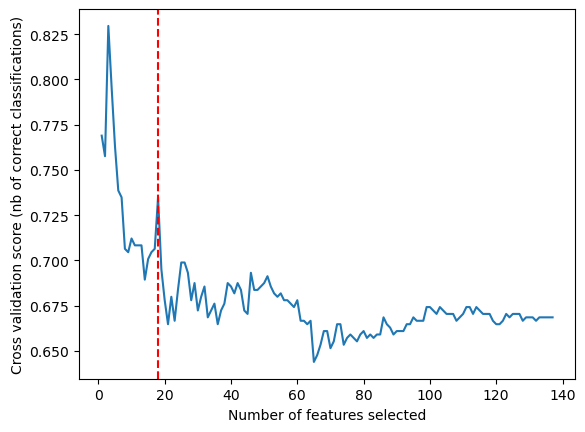

In [7]:
"""Preprocessing the data including RFECV"""
#This data is scaled (standardized), a variance and correlation threshold are applied,
# and RFECV brought back the number of features to 18

#Train data
data_rfecv, df_label, variance_data, selected_columns, drop_correlation, scaler, rfecv, selected_features = processing_data_rfecv(data_train)

#Test data
data_rfecv_test, df_label_rfecv_test = processing_data_rfecv_test(data_test, variance_data, selected_columns, drop_correlation, scaler, rfecv, selected_features)

#data_rfecv and data_rfecv_test are the inputs for the SVM

In [9]:
"""Encoding the labels"""
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(['lipoma', 'liposarcoma'])

# Encode training labels
Y = label_encoder.transform(df_label['label'])  # Train labels


In [10]:
"""Support Vector Machine"""
# Defining the data to use for this classifier
X = data_rfecv  # Features

# Set up the parameter grid for GridSearchCV
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [3, 4, 5], 'gamma': ['scale', 'auto', 0.1, 1], 'coef0': [0.0, 0.1, 0.5]},
]

# Set up the SVM classifier
svm_classifier = SVC(random_state=42, probability=True)  # Enable probability for AUC calculation

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=svm_classifier,
    param_grid=param_grid,
    scoring='roc_auc',         # Optimize AUC score
    refit=True,                # Refit best model on full training data
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model_svm = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model_svm.predict(X)
y_pred_proba = best_model_svm.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 123 candidates, totalling 615 fits
Best hyperparameters: {'C': 1, 'kernel': 'linear'}
Training AUC: 0.9844


In [11]:
"""Random Forest Classifier"""
# Defining the data to use for this classifier
X = df_processed_scaling # Features

# Set up parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [4, 5, 10, 15, 20],
    'max_features': ['sqrt', 'log2']
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Inner CV for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for best hyperparameters
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    refit=True,
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X, Y)

# Best model after Grid Search
best_model_rf = grid_search.best_estimator_

# Make predictions
y_pred = best_model_rf.predict(X)
y_pred_proba = best_model_rf.predict_proba(X)[:, 1]  # Probability for positive class

# Evaluate model performance
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
Training AUC: 0.9986


In [12]:
"""KNNeighbour classifier"""
# Defining the data to use for this classifier
X = df_processed_scaling # Features

# Set up the parameter grid for GridSearchCV (for KNN, we mainly tune 'n_neighbors', 'weights', and 'metric')
param_grid = {
    'n_neighbors': [5, 7, 10, 15, 20],  # Trying different values for k (number of neighbors)
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'metric': ['euclidean', 'manhattan']  # Distance metrics to use
}

# Set up the KNN classifier
knn_classifier = KNeighborsClassifier()  # KNN classifier

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=knn_classifier,
    param_grid=param_grid,
    cv=inner_cv,
    n_jobs=-1,
    verbose=1,
    scoring='roc_auc',         # Optimize AUC score
    refit=True,                # Refit best model on full training data
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model_knn = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model_knn.predict(X)
y_pred_proba = best_model_knn.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Training AUC: 1.0000


<class 'sklearn.svm._classes.SVC'>
Acc: 0.7826, AUC: 0.7955, F1: 0.7619, Precision: 0.8000, Recall: 0.7273
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Acc: 0.6957, AUC: 0.7576, F1: 0.6316, Precision: 0.7500, Recall: 0.5455
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Acc: 0.6957, AUC: 0.7273, F1: 0.5882, Precision: 0.8333, Recall: 0.4545


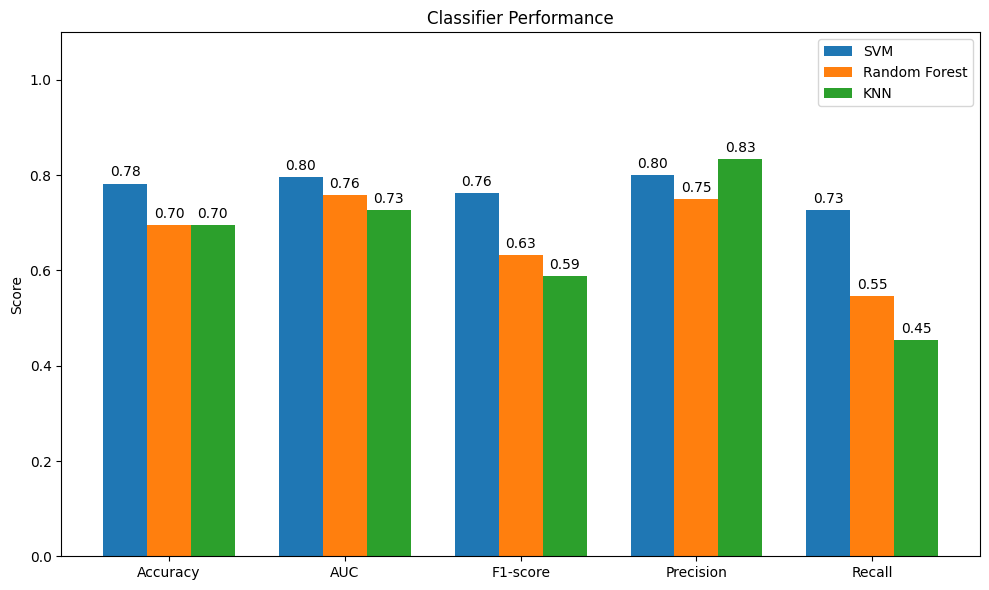

In [17]:
"""Testing the classifiers on the test data"""
X = data_rfecv_test  # Features
Y = label_encoder.transform(df_label_rfecv_test['label'])  # Encoded labels

clsfs = [best_model_svm, best_model_rf, best_model_knn]
classifier_names = ['SVM', 'Random Forest', 'KNN']

# Lists to store metrics
accuracies = []
aucs = []
f1s = []
precisions = []
recalls = []

for clf in clsfs:
    y_pred = clf.predict(X)

    # If predictions are strings, encode them
    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)

    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X)[:, 1]
    else:
        y_score = y_pred

    # Compute metrics
    auc = metrics.roc_auc_score(Y, y_score)
    accuracy = metrics.accuracy_score(Y, y_pred)
    f1 = metrics.f1_score(Y, y_pred, pos_label=1)
    precision = metrics.precision_score(Y, y_pred, pos_label=1)
    recall = metrics.recall_score(Y, y_pred, pos_label=1)

    # Save them for plotting
    accuracies.append(accuracy)
    aucs.append(auc)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    # Optional: print for debugging
    print(type(clf))
    print(f'Acc: {accuracy:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


"""Plotting the classifier performances dynamically"""
metrics_names = ['Accuracy', 'AUC', 'F1-score', 'Precision', 'Recall']
metric_values = np.array([accuracies, aucs, f1s, precisions, recalls]).T

x = np.arange(len(metrics_names))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars = []

# Plot each classifier's metrics
for i, classifier in enumerate(classifier_names):
    bars.append(ax.bar(x + (i - 1) * bar_width, metric_values[i], bar_width, label=classifier))

# Labels and ticks
ax.set_ylabel('Score')
ax.set_title('Classifier Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1.1)
ax.legend()

# Add labels to bars
def add_labels(bar_group):
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

for bar_group in bars:
    add_labels(bar_group)

plt.tight_layout()
plt.show()